In [2]:
!pip install azure-cognitiveservices-vision-computervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 10.5 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing image: /content/sample_data/image.png
Detected objects:
  - Toy (0.50) at (0, 38, 241, 331)
  - person (0.67) at (242, 46, 228, 311)


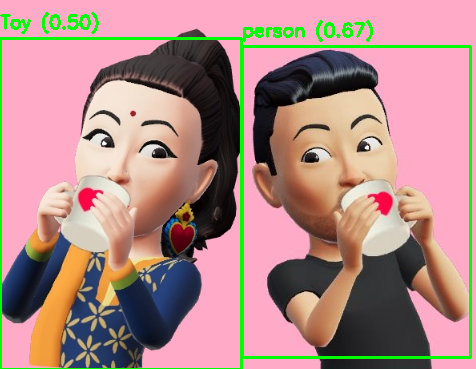

In [7]:
import os
import cv2
import time
import io
import numpy as np
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from msrest.authentication import CognitiveServicesCredentials
from google.colab import drive
from google.colab.patches import cv2_imshow
from google.colab import userdata

# --- 1. Mount Google Drive and Get Credentials ---
# Mount your Google Drive to access files
drive.mount('/content/drive')

# Retrieve Azure credentials from Colab's secrets manager
try:
    AZURE_ENDPOINT = userdata.get('AZURE_ENDPOINT')
    AZURE_KEY = userdata.get('AZURE_KEY')
except Exception as e:
    print("Error retrieving secrets. Please ensure AZURE_ENDPOINT and AZURE_KEY are set in Colab secrets.")
    print(e)
    exit()

# Authenticate with Azure
try:
    computervision_client = ComputerVisionClient(AZURE_ENDPOINT, CognitiveServicesCredentials(AZURE_KEY))
except Exception as e:
    print(f"Error authenticating with Azure: {e}")
    exit()

# --- 2. Processing Functions ---

def process_image(image_path):
    """
    Processes a single image file for object detection.
    """
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
        return

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return

    print(f"Processing image: {image_path}")

    # Encode image to a stream for Azure API
    is_success, buffer = cv2.imencode(".jpg", image)
    if not is_success:
        print("Error: Could not encode image to stream.")
        return

    # Wrap bytes in an io.BytesIO object
    image_stream = io.BytesIO(buffer)

    try:
        # Call Azure API for object detection
        analysis = computervision_client.analyze_image_in_stream(
            image_stream, visual_features=['Objects']
        )

        if analysis.objects:
            print("Detected objects:")
            for obj in analysis.objects:
                rect = obj.rectangle
                label = f"{obj.object_property} ({obj.confidence:.2f})"
                print(f"  - {label} at ({rect.x}, {rect.y}, {rect.w}, {rect.h})")

                # Draw bounding box and label
                cv2.rectangle(image, (rect.x, rect.y), (rect.x + rect.w, rect.y + rect.h), (0, 255, 0), 2)
                cv2.putText(image, label, (rect.x, rect.y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        else:
            print("No objects detected in the image.")

        # Display the image in Colab
        cv2_imshow(image)

    except Exception as e:
        print(f"Azure API error: {e}")

def process_video(video_path):
    """
    Processes a video file for object detection and tracking.
    """
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return

    print(f"Processing video: {video_path}. Press 'q' to exit.")

    frame_count = 0
    azure_detection_interval = 30
    tracked_objects = {}

    while True:
        ret, frame = cap.read()
        if not ret:
            print("End of video file.")
            break

        frame_count += 1

        if frame_count % azure_detection_interval == 0:
            is_success, buffer = cv2.imencode(".jpg", frame)
            if not is_success:
                print("Error: Could not encode frame.")
                continue
            image_stream = io.BytesIO(buffer)

            try:
                analysis = computervision_client.analyze_image_in_stream(
                    image_stream, visual_features=['Objects']
                )

                new_tracked_objects = {}
                if analysis.objects:
                    for i, obj in enumerate(analysis.objects):
                        obj_id = f"{obj.object_property}_{i}"
                        new_tracked_objects[obj_id] = {
                            'label': obj.object_property,
                            'confidence': obj.confidence,
                            'bbox': (obj.rectangle.x, obj.rectangle.y, obj.rectangle.w, obj.rectangle.h)
                        }
                tracked_objects = new_tracked_objects
            except Exception as e:
                print(f"Azure API error: {e}")
                pass

        if tracked_objects:
            for obj_id, data in tracked_objects.items():
                x, y, w, h = data['bbox']
                label = f"{data['label']} ({data['confidence']:.2f})"

                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        cv2_imshow(frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    print("Application shut down.")

# --- 3. Main Execution in Colab ---
if __name__ == "__main__":
    # Define paths to your files in Google Drive
    #base_path = "/content/drive/My Drive/assets/"

    # ⚠️ IMPORTANT: Update these paths to match the exact names of your files
    image_file = "/content/sample_data/image.png"
    video_file = "/content/sample_data/vedeo.mp4"

    # To process a file, simply uncomment the function call.
    # Note: You should only run one of these at a time.

    # 1. Process an image file
    process_image(image_file)

    # 2. Process a video file
    # process_video(video_file)